In [1]:
####
#Loading in necessary libraries
####
from math import exp
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
#Note: I will sometimes include a reload of a library in later cells, to allow them to be run autonomously, 
#without needing the entire file to be run. 
#Some of the cells can take 30-45 seconds to run.

## Part 1: Creating training and testing datasets

In [2]:
###
# 1.1 Loading in the data
###
df = pd.read_csv('data/heart_disease_cleaned_1.csv')

print(df.columns)

print(df.shape) #714,16



Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal',
       'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')
(746, 16)


In [3]:
x=df.drop('HeartDisease', axis=1)
y=df['HeartDisease']
#
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=5)

print(X_train.shape)
print(X_test.shape)

(596, 15)
(150, 15)


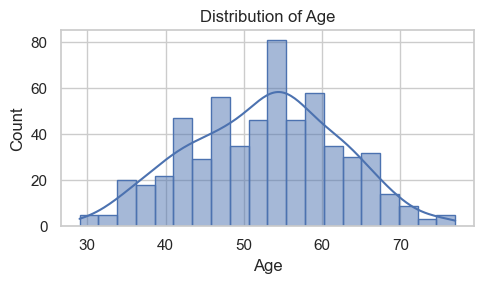

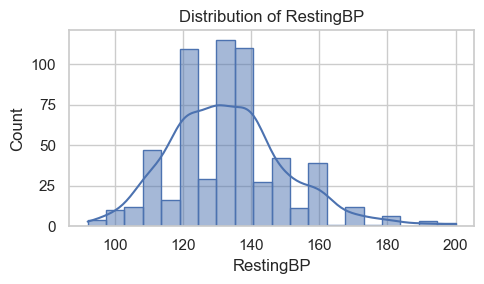

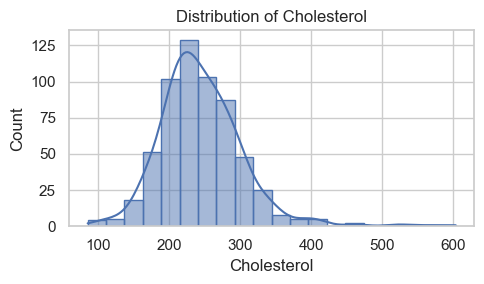

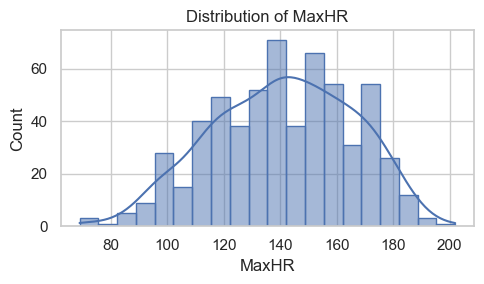

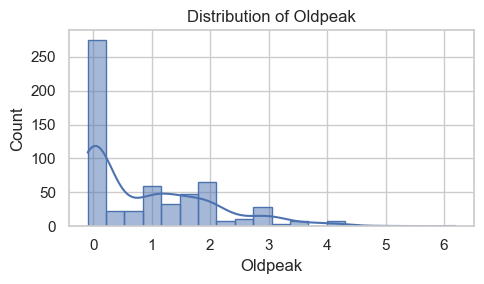

In [4]:
sns.set_theme(style="whitegrid") #Just checking here that training and testing set generation retained distribution shape

continuous_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in continuous_vars:
    plt.figure(figsize=(5,3))
    sns.histplot(X_train[col], bins=20, alpha=0.5, edgecolor="b", kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [5]:
####
#1.2 Scaling the continuous variables
####
#As I intend to perform logistic regression, the continuous variables must be scaled. 
#Here, I am scaling through z-score standardisation
continuous_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
#
scaler = StandardScaler()
scaler.fit(X_train[continuous_vars]) #Use the mean and standard deviation of the TRAINING set, to ensure no dataleak!!
#
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()
#
X_train_scaled[continuous_vars]=scaler.transform(X_train[continuous_vars])
X_test_scaled[continuous_vars]=scaler.transform(X_test[continuous_vars])


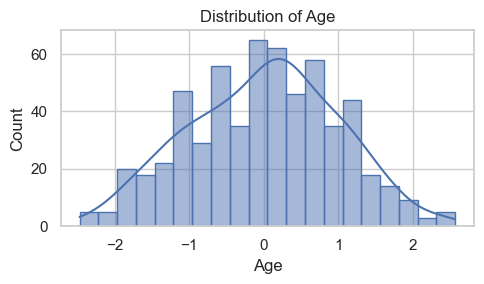

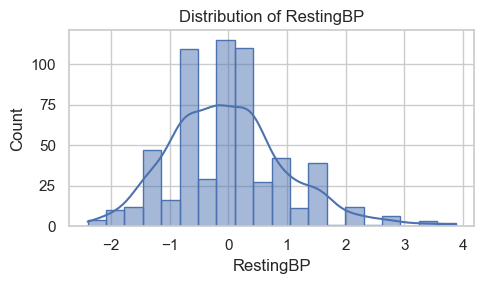

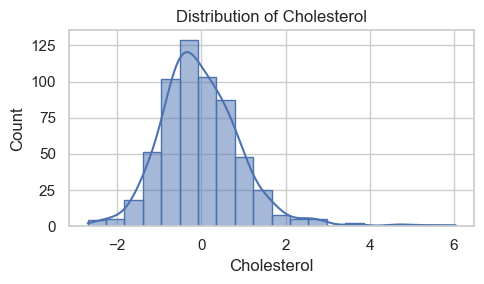

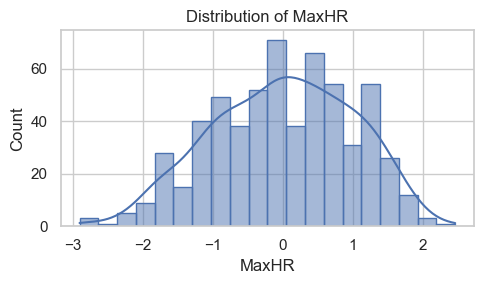

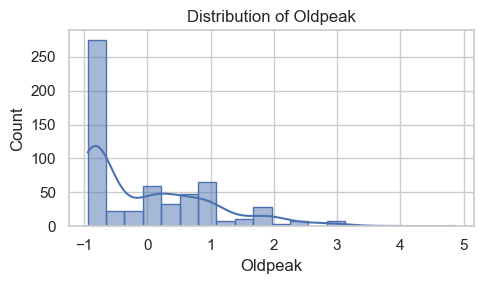

In [6]:
sns.set_theme(style="whitegrid")

continuous_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in continuous_vars:
    plt.figure(figsize=(5,3))
    sns.histplot(X_train_scaled[col], bins=20, alpha=0.5, edgecolor="b", kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

## Part 2: Running Logistic Regression (with Ridge Regularisation)

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

In [8]:
####
#2.1 Compiling the model
####
lrcv = LogisticRegressionCV(
    Cs=20, #double up on the default number of lambdas that are tested, I want the best one
    cv=5, #use 5 fold cross validation, that scores based on sensitivity (below)
    scoring="recall", #Sensitivity in a biomedical context is a key performance metric, see Discussion section
    penalty="l2", #apply ridge regularisation, which uses the default lbfgs solver, too few features for LASSO
    solver="lbfgs", #recommended in the lectures
    max_iter=500, #make many iterations so model can converge
    refit=True, #after a good C is found, refit the whole model based on that C automatically
    random_state=100,
    n_jobs=-1 #use all processors available, also ensures older devices can run this
)
####
#2.2 Fitting the model
####
lrcv.fit(X_train_scaled, y_train)
print("Best C:", lrcv.C_[0])
####
#2.3 Making inferences from the model
####
y_pred=lrcv.predict(X_test_scaled)
y_prob=lrcv.predict_proba(X_test_scaled)[:,1]
#


Best C: 0.615848211066026


In [9]:
####
#2.3 Finding Metrics and Plotting ROC Curve
####
print("Logistic Regression")
#
print(f"Sensitivity, {recall_score(y_test, y_pred)}")
#
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")
#
print(f"Accuracy, {accuracy_score(y_test, y_pred)}")
#
print(f"ROC-AUC, {roc_auc_score(y_test, y_prob)}")



#
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0, 1]))

Logistic Regression
Sensitivity, 0.8985507246376812
Specificity: 0.8641975308641975
Accuracy, 0.88
ROC-AUC, 0.908928251923421


,0,1
0,70,11
1,7,62


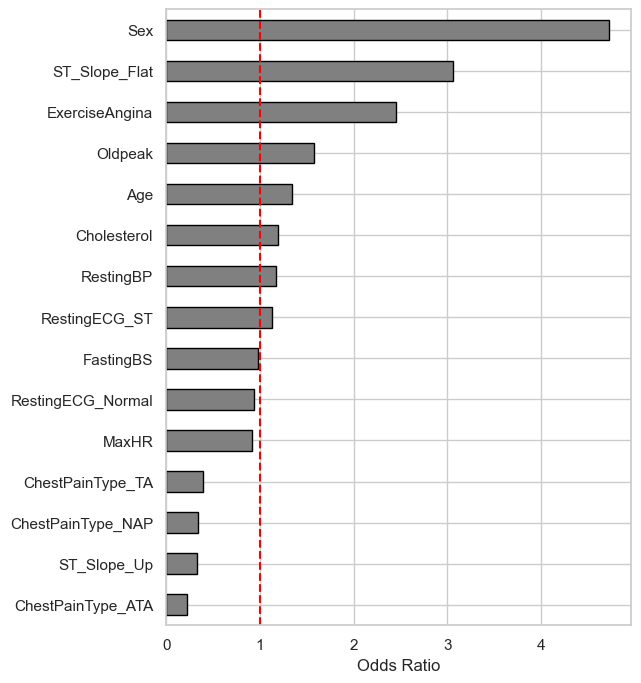

In [10]:
####
#2.4 Evaluating the model's coefficients. AND FORMING FIGURE 3!
####
#Make a series of each column and its respective coefficient, index it by column name so after sorting, the coefficient's
#term can still be found
lr_coefficients=pd.Series(lrcv.coef_[0], index=X_train_scaled.columns)
#print(lr_coefficients)
#Find the odds ratios by taking the exponent, see week 3 lectures
lr_oddsR=np.exp(lr_coefficients)
#Sort the odds ratios
lr_oddsR_sorted=lr_oddsR.sort_values(ascending=False, kind="quicksort")
#print(lr_oddsR_sorted)
#Now, plot the odds ratios
plt.figure(figsize=(6,8))
lr_oddsR_sorted.sort_values(ascending=True).plot(kind="barh", color="gray", edgecolor="black")
plt.axvline(x=1, color='red', linestyle='--', label='Odds ratio = 1')
plt.xlabel("Odds Ratio")
plt.show()


In [11]:
#Pickling the logistic regrression model (as described in the discussion).
import pickle
with open("final_model.pkl", "wb") as file:
    pickle.dump(lrcv, file)

## Part 3: Running ensemble method - Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

In [13]:
####
#3.1 Compiling the model
####
rf = RandomForestClassifier(
    n_estimators=250, #I want 250 trees as roughly suggested in the lectures
    max_depth=None, #Allow trees to fully grow
    bootstrap=True, #Allow bootstrap aggregation, which reduces variance by generating each training dataset through bootstrap
    max_features="sqrt", #To decorrelate the trees, the square root of the number of parameters were considered at each decision node.
    random_state=100,
    n_jobs=-1 #use all processors
)
####
#3.2 Fitting the model
####
rf.fit(X_train_scaled, y_train)
####
#3.3 Making inferences from the model
####
y_pred=rf.predict(X_test_scaled)
y_prob=rf.predict_proba(X_test_scaled)[:,1]
#

In [14]:
####
#2.3 Finding Metrics and Plotting ROC Curve
####
print("Random Forest")
#
print(f"Sensitivity, {recall_score(y_test, y_pred)}")
#
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")
#
print(f"Accuracy, {accuracy_score(y_test, y_pred)}")
#
print(f"ROC-AUC, {roc_auc_score(y_test, y_prob)}")



#
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0, 1]))

Random Forest
Sensitivity, 0.8695652173913043
Specificity: 0.8271604938271605
Accuracy, 0.8466666666666667
ROC-AUC, 0.9005188763642871


,0,1
0,67,14
1,9,60


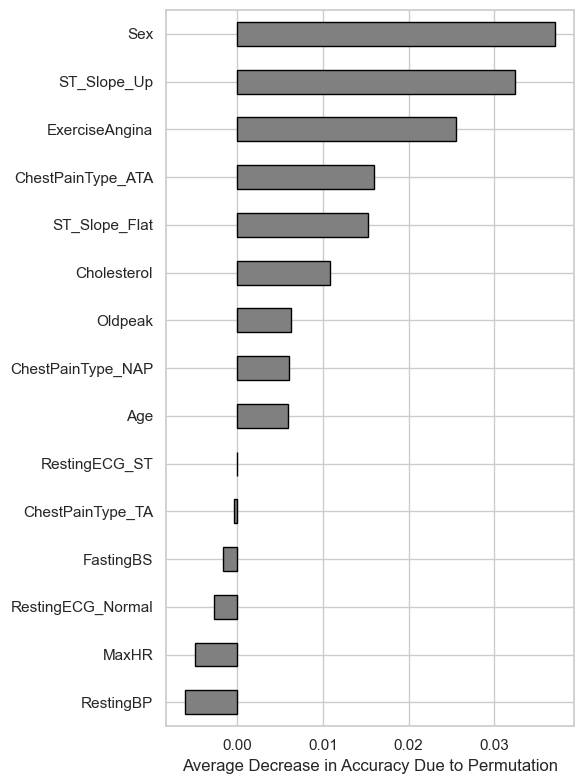

In [15]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Plotting the importance using permutation based procdure
result = permutation_importance(
    rf,
    X_test_scaled, y_test,
    n_repeats=35, #For 35 times, permute each features, and the average the model's accuracy
    random_state=100,
    n_jobs=-1                    
)

# Put into a series, indexed by column names
permutation_importance = pd.Series(result.importances_mean, index=X_test_scaled.columns)

# Sort the permutation based importance
permutation_importance_sorted = permutation_importance.sort_values(ascending=True)

######
#FORMING FIGURE 4!
######
#Now, plot the permutation based importance
plt.figure(figsize=(6,8))
permutation_importance_sorted.plot(kind='barh', color='gray', edgecolor="black")
plt.xlabel("Average Decrease in Accuracy Due to Permutation")
plt.tight_layout()
plt.show()

## Part 3: Running ensemble method - AdaBoost

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

####
#4.1 Compiling the model
####
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=100) #base estimator is stump

ada = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=250, #Use 250 trees, all are stumps
    learning_rate=1.0, #Constrain learning rate to standard nu
    random_state=100
)

####
#4.2 Fitting the model
####
ada.fit(X_train_scaled, y_train)

####
#4.3 Making inferences from the model
####
y_pred = ada.predict(X_test_scaled)
y_prob = ada.predict_proba(X_test_scaled)[:, 1]

In [17]:
####
#2.3 Finding Metrics and Plotting ROC Curve
####
print("Adaboost")
#
print(f"Sensitivity, {recall_score(y_test, y_pred)}")
#
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")
#
print(f"Accuracy, {accuracy_score(y_test, y_pred)}")
#
print(f"ROC-AUC, {roc_auc_score(y_test, y_prob)}")
#
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0, 1]))

Adaboost
Sensitivity, 0.8115942028985508
Specificity: 0.8395061728395061
Accuracy, 0.8266666666666667
ROC-AUC, 0.8692073716228306


,0,1
0,68,13
1,13,56


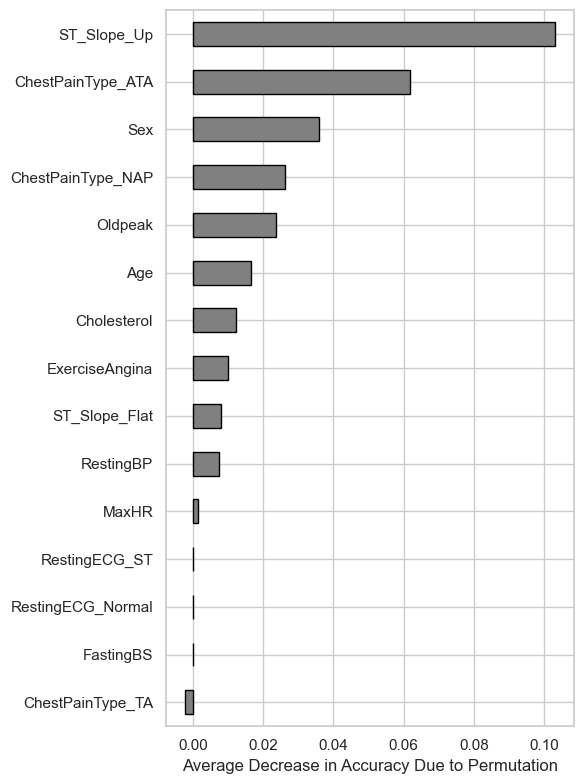

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Plotting the importance using permutation based procdure
result = permutation_importance(
    ada,
    X_test_scaled, y_test,
    n_repeats=35, #For 35 times, permute each features, and the average the model's accuracy
    random_state=100,
    n_jobs=-1
)

# Put into a series, indexed by column names
permutation_importance = pd.Series(result.importances_mean, index=X_test_scaled.columns)

# Sort the series
permutation_importance_sorted = permutation_importance.sort_values(ascending=True)


#####
#FORMING FIGURE 5!
#####
plt.figure(figsize=(6,8))
#Now, plot the permutatino based importance
permutation_importance_sorted.plot(kind='barh', color='gray', edgecolor="black")
plt.xlabel("Average Decrease in Accuracy Due to Permutation")
plt.tight_layout()
plt.show()